In [19]:
from river.river import River
from river.preprocess import do_slat_pair, get_the_feature, seed_everything
import pysodb 
import scanpy as sc
import numpy as np
import anndata as ad

seed_everything(42)

sodb = pysodb.SODB()

import squidpy as sq
 
experiment_list = ['BALBc-1', 'BALBc-2', 'BALBc-3', 'MRL-4','MRL-5','MRL-6','MRL-7','MRL-8', 'MRL-9']
 
adata_list_total = []
for i, experiment in enumerate(experiment_list):
    adata = sodb.load_experiment('Goltsev2028deep', experiment)
    if i > 2:
        adata.obs['label'] = 'MPL'
    else:
        adata.obs['label'] = 'BALB'
    adata_list_total.append(adata)

adata_list = [sc.pp.subsample(adata_list_total[0], n_obs=20000, copy=True), sc.pp.subsample(adata_list_total[3], n_obs=20000, copy=True)]

rem_adata_list = []
label_list = []
y = []
X_1 = []
X_2 = []
X_3 = []
X_full = []


final_ranks = np.load('final_rank_lupus.npy', allow_pickle=True)

for i, adata in enumerate(adata_list_total):
    if (i !=0) and (i != 3):
        if i > 2:
            adata.obs['label'] = 'MPL'
        else:
            adata.obs['label'] = 'BALB'
        y.append(i > 2)
        X_1.append(adata[:, final_ranks[:3]].X.mean(0))
        X_2.append(adata[:, final_ranks[:5]].X.mean(0))
        X_3.append(adata[:, final_ranks[:10]].X.mean(0))
        X_full.append(adata.X.mean(0))
        rem_adata_list.append(adata)      
        

rem_adata = ad.concat(rem_adata_list, label='slice_id')


X_list = []
X_ctrl_list = []
np.random.seed(42)
random_ranks = np.random.permutation(np.arange(final_ranks.shape[0]))

for i in range(0, 10, 2):
    X_list.append(np.stack([rem_adata[rem_adata.obs['slice_id'] == s, final_ranks[:min(i+2, final_ranks.shape[0])]].X.mean(0)  for s in rem_adata.obs['slice_id'].unique()]))
    X_ctrl_list.append(np.stack([rem_adata[rem_adata.obs['slice_id'] == s, random_ranks[:min(i+2, final_ranks.shape[0])]].X.mean(0)  for s in rem_adata.obs['slice_id'].unique()]))
    
X_list.append(np.stack([rem_adata[rem_adata.obs['slice_id'] == s].X.mean(0)  for s in rem_adata.obs['slice_id'].unique()]))
X_ctrl_list.append(np.stack([rem_adata[rem_adata.obs['slice_id'] == s].X.mean(0)  for s in rem_adata.obs['slice_id'].unique()]))

load experiment[BALBc-1] in dataset[Goltsev2028deep]
load experiment[BALBc-2] in dataset[Goltsev2028deep]
load experiment[BALBc-3] in dataset[Goltsev2028deep]
load experiment[MRL-4] in dataset[Goltsev2028deep]
load experiment[MRL-5] in dataset[Goltsev2028deep]
load experiment[MRL-6] in dataset[Goltsev2028deep]
load experiment[MRL-7] in dataset[Goltsev2028deep]
load experiment[MRL-8] in dataset[Goltsev2028deep]
load experiment[MRL-9] in dataset[Goltsev2028deep]


In [ ]:

matching_list = []

for i, adata in enumerate(adata_list[1:]):
    _, best =  do_slat_pair(adata_list[0], adata, feature='raw')
    matching_list.append(best[0])
gene_expression, spatial, y, overlap = get_the_feature(adata_list, matching_list)
model = River(gene_expression=gene_expression, spatial=spatial, label=y)
model.train(epoch=100)
ig_attribution, dl_attribution, sl_attribution = model.attribution()
model.summary_attribution(ig_attribution, dl_attribution, sl_attribution, overlap)
model.return_top_k_gene(top_k=200)


np.save('final_rank_lupus', model.final_rank.index.values)
np.save('ig_lupus', model.scores_ig)
np.save('dl_lupus', model.scores_dl)
np.save('sl_lupus', model.scores_sl)

/tmp/ipykernel_252884/3451686439.py:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


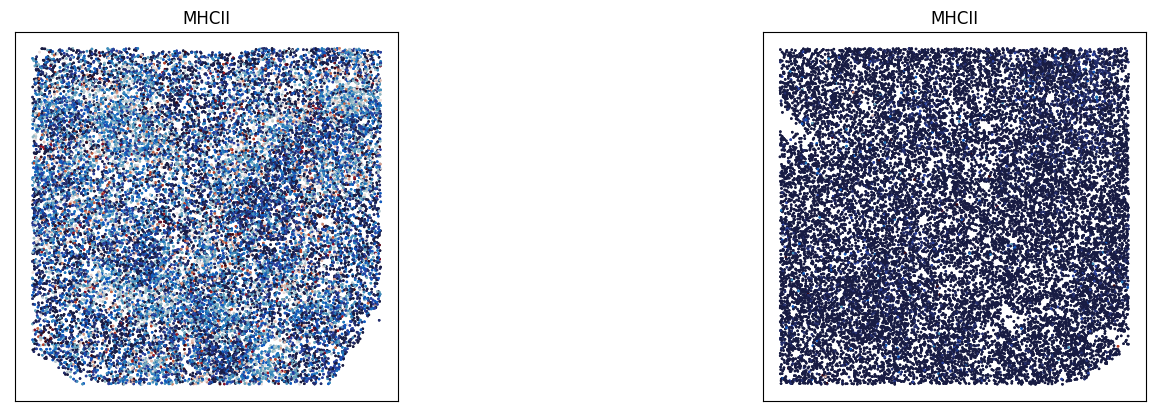

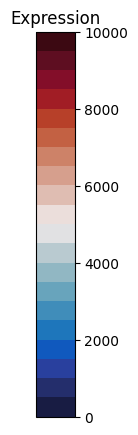

/tmp/ipykernel_252884/3451686439.py:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


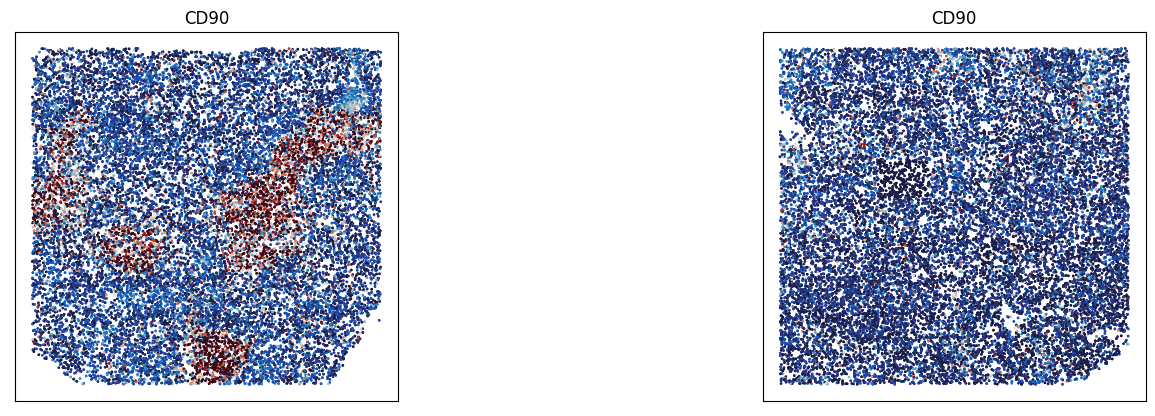

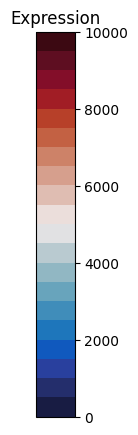

/tmp/ipykernel_252884/3451686439.py:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


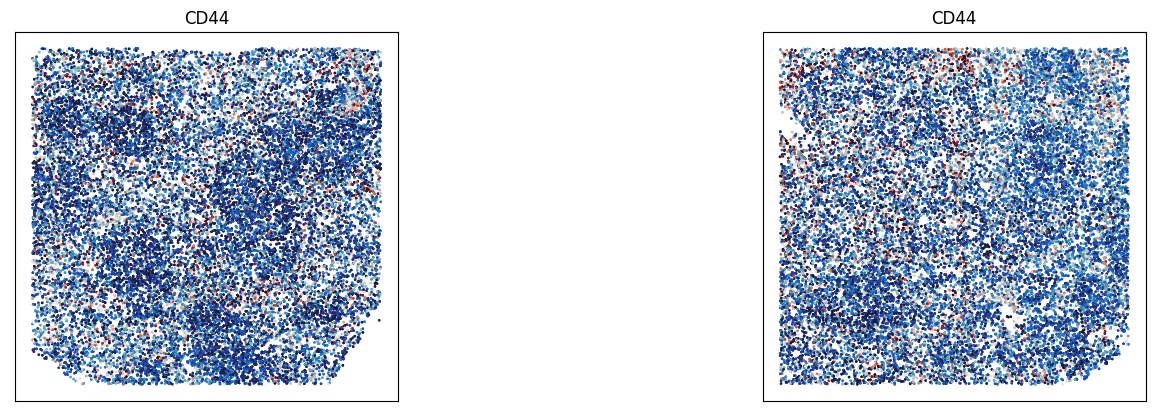

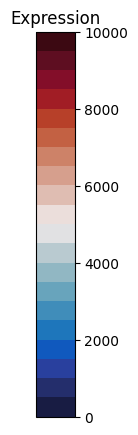

In [3]:
import squidpy as sq 
import anndata as ad
import matplotlib.pyplot as plt

r1 = np.load('final_rank_lupus.npy', allow_pickle=True)

adata = ad.concat(adata_list, label='slice_id')

from palettable.cmocean.diverging import Delta_20, Balance_20

from matplotlib.colors import  ListedColormap



for i in range(3):

    norm = plt.Normalize(0, 10000)

    cmap = ListedColormap(Balance_20.mpl_colors)
    
    g = sq.pl.spatial_scatter(ad.concat(adata_list, label='slice_id'), shape=None, color=[r1[i]], ncols=3, library_key='slice_id', cmap=cmap, return_ax=True, wspace=0.3, norm=norm, colorbar=False)

    for j, ax in enumerate(g):
        if j > 2:
            ax.set_title('') 
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    fig_colorbar, ax_colorbar = plt.subplots(figsize=(0.5, 5))
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax_colorbar)
    ax_colorbar.set_title('Expression')
    plt.tight_layout()
    plt.show()


/data/civy/miniconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/data/civy/miniconda3/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


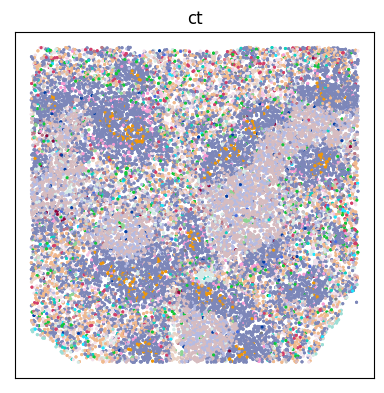

/data/civy/miniconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/data/civy/miniconda3/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


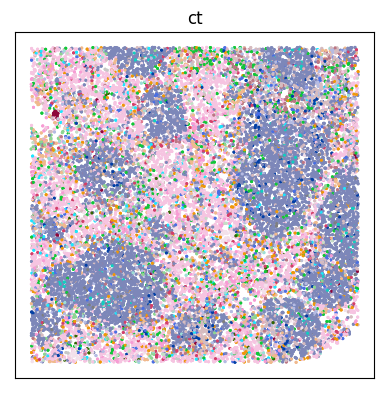

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


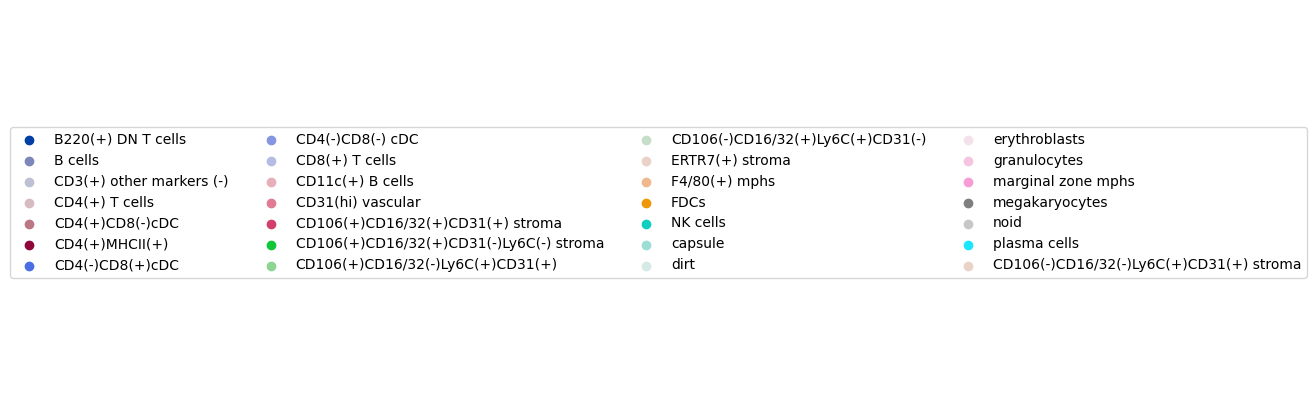

In [4]:
import squidpy as sq 
import anndata as ad
import matplotlib.pyplot as plt

r1 = np.load('final_rank_lupus.npy', allow_pickle=True)

adata = ad.concat(adata_list, label='slice_id')

from palettable.cmocean.diverging import Delta_20, Balance_20

from matplotlib.colors import  ListedColormap

plot = ad.concat(adata_list, label='slice_id')

all_handles_labels = []

for i, s in enumerate(plot.obs['slice_id'].unique()):

    g = sq.pl.spatial_scatter(plot[plot.obs['slice_id'] == s], shape=None, color=['ct'], ncols=3, library_key='slice_id', return_ax=True, wspace=0.3, colorbar=False, library_id=[s])

    g = [g]

    for j, ax in enumerate(g):
        if j > 2:
            ax.set_title('') 
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.get_legend().remove()
        handles, labels = ax.get_legend_handles_labels()
        for handle, label in zip(handles, labels):
            if label not in [l for _, l in all_handles_labels]:
                if (label != '0.0') & (label != '1.0') & (label != 'True') & (label != 'False') & (label != '0'):
                    all_handles_labels.append((handle, label))

   
    plt.tight_layout()
    plt.show()

unique_handles_labels =  dict(all_handles_labels).items()

# Create a new figure for the comprehensive legend
fig_legend, ax_legend = plt.subplots(figsize=(10, 5))  # Adjust size as needed
fig_legend.legend(*zip(*unique_handles_labels), loc='center', ncol=4)
ax_legend.axis('off')
plt.show()


In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Perform 5-fold cross-validation for different subsets of features
results = {}
means_1 = []
std_1 = []
methods = []
res_1 = []

for i, X in enumerate(X_list[:5]):
    clf = SVC(random_state=42)
    # StratifiedKFold preserves the percentage of samples for each class.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_list[i], y, cv=cv, scoring='accuracy')
    results[i] = scores
    res_1.append(scores)
    means_1.append(scores.mean())
    std_1.append(scores.std())



# Converting results to DataFrame for easy plotting
'''results_df = pd.DataFrame(results)


# Plotting
plt.figure(figsize=(10, 10))
import seaborn as sns
ax = sns.heatmap(results_df.T, cbar=False, annot=True, fmt='.2f', cmap='flare', 
                 yticklabels=['Top-3', 'Top-5', 'Top-10', 'Full'], xticklabels=['Fold1', 'Fold2', 'Fold3', 'Fold4', 'Fold5'])'''


results = {}
means_2 = []
std_2 = []
res_2 = []

for i, X in enumerate(X_list[:5]):
    clf =  RandomForestClassifier(random_state=42)
    # StratifiedKFold preserves the percentage of samples for each class.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_list[i], y, cv=cv, scoring='accuracy')
    results[i] = scores
    res_2.append(scores)
    means_2.append(scores.mean())
    std_2.append(scores.std())
# Converting results to DataFrame for easy plotting
results_df = pd.DataFrame(results)

# Creating line chart with error bars
# Plotting
'''plt.figure(figsize=(10, 10))
import seaborn as sns
ax = sns.heatmap(results_df.T, cbar=False, annot=True, fmt='.2f', cmap='flare', 
                 yticklabels=['Top-3', 'Top-5', 'Top-10', 'Full'], xticklabels=['Fold1', 'Fold2', 'Fold3', 'Fold4', 'Fold5'])'''


results = {}
means_3 = []
std_3 = []
res_3 = [ ]


for i, X in enumerate(X_list[:5]):
    clf =  LogisticRegression(random_state=42)
    # StratifiedKFold preserves the percentage of samples for each class.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_list[i], y, cv=cv, scoring='accuracy')
    results[i] = scores
    res_3.append(scores)
    means_3.append(scores.mean())
    std_3.append(scores.std())
# Converting results to DataFrame for easy plotting
results_df = pd.DataFrame(results)



# Plotting
'''plt.figure(figsize=(10, 10))
import seaborn as sns
ax = sns.heatmap(results_df.T, cbar=False, annot=True, fmt='.2f', cmap='flare', 
                 yticklabels=['Top-3', 'Top-5', 'Top-10', 'Full'], xticklabels=['Fold1', 'Fold2', 'Fold3', 'Fold4', 'Fold5'])'''


/data/civy/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/data/civy/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/data/civy/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/data/civy/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/data/civy/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warni

"plt.figure(figsize=(10, 10))\nimport seaborn as sns\nax = sns.heatmap(results_df.T, cbar=False, annot=True, fmt='.2f', cmap='flare', \n                 yticklabels=['Top-3', 'Top-5', 'Top-10', 'Full'], xticklabels=['Fold1', 'Fold2', 'Fold3', 'Fold4', 'Fold5'])"

In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Perform 5-fold cross-validation for different subsets of features
results = {}
res_c_1 = []
means_c_1 = []
std_c_1 = []
methods = []

for i, X in enumerate(X_ctrl_list[:5]):
    clf = SVC(random_state=42)
    # StratifiedKFold preserves the percentage of samples for each class.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_ctrl_list[i], y, cv=cv, scoring='accuracy')
    print(scores)
    print(scores.mean() + scores.std())
    results[i] = scores
    res_c_1.append(scores)
    means_c_1.append(scores.mean())
    std_c_1.append(scores.std())


# Converting results to DataFrame for easy plotting
'''results_df = pd.DataFrame(results)


# Plotting
plt.figure(figsize=(10, 10))
import seaborn as sns
ax = sns.heatmap(results_df.T, cbar=False, annot=True, fmt='.2f', cmap='flare', 
                 yticklabels=['Top-3', 'Top-5', 'Top-10', 'Full'], xticklabels=['Fold1', 'Fold2', 'Fold3', 'Fold4', 'Fold5'])'''


results = {}
res_c_2 = []
means_c_2 = []
std_c_2 = []


for i, X in enumerate(X_ctrl_list[:5]):
    clf =  RandomForestClassifier(random_state=42)
    # StratifiedKFold preserves the percentage of samples for each class.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_ctrl_list[i], y, cv=cv, scoring='accuracy')
    results[i] = scores
    res_c_2.append(scores)
    means_c_2.append(scores.mean())
    std_c_2.append(scores.std())
# Converting results to DataFrame for easy plotting
results_df = pd.DataFrame(results)


# Plotting
'''plt.figure(figsize=(10, 10))
import seaborn as sns
ax = sns.heatmap(results_df.T, cbar=False, annot=True, fmt='.2f', cmap='flare', 
                 yticklabels=['Top-3', 'Top-5', 'Top-10', 'Full'], xticklabels=['Fold1', 'Fold2', 'Fold3', 'Fold4', 'Fold5'])'''


results = {}
means_c_3 = []
std_c_3 = []
res_c_3 = []


for i, X in enumerate(X_ctrl_list[:5]):
    clf =  LogisticRegression(random_state=42)
    # StratifiedKFold preserves the percentage of samples for each class.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_ctrl_list[i], y, cv=cv, scoring='accuracy')
    results[i] = scores
    res_c_3.append(scores)
    means_c_3.append(scores.mean())
    std_c_3.append(scores.std())
# Converting results to DataFrame for easy plotting
results_df = pd.DataFrame(results)




# Plotting
'''plt.figure(figsize=(10, 10))
import seaborn as sns
ax = sns.heatmap(results_df.T, cbar=False, annot=True, fmt='.2f', cmap='flare', 
                 yticklabels=['Top-3', 'Top-5', 'Top-10', 'Full'], xticklabels=['Fold1', 'Fold2', 'Fold3', 'Fold4', 'Fold5'])'''


/data/civy/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/data/civy/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/data/civy/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/data/civy/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/data/civy/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warni

[0.5 0.5 1.  1.  1. ]
1.0449489742783178
[0.5 0.5 1.  1.  1. ]
1.0449489742783178
[0.5 0.5 1.  1.  1. ]
1.0449489742783178
[0.5 0.5 1.  1.  1. ]
1.0449489742783178
[0.5 0.5 1.  1.  1. ]
1.0449489742783178


/data/civy/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/data/civy/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/data/civy/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/data/civy/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/data/civy/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warni

"plt.figure(figsize=(10, 10))\nimport seaborn as sns\nax = sns.heatmap(results_df.T, cbar=False, annot=True, fmt='.2f', cmap='flare', \n                 yticklabels=['Top-3', 'Top-5', 'Top-10', 'Full'], xticklabels=['Fold1', 'Fold2', 'Fold3', 'Fold4', 'Fold5'])"

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


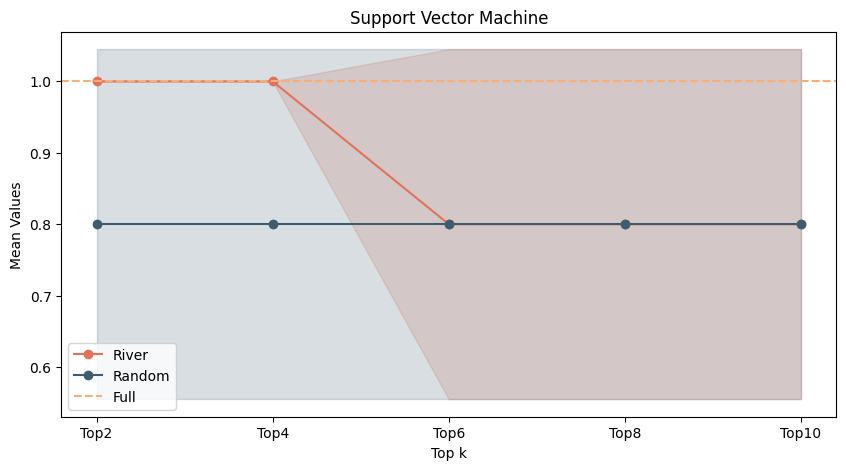

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


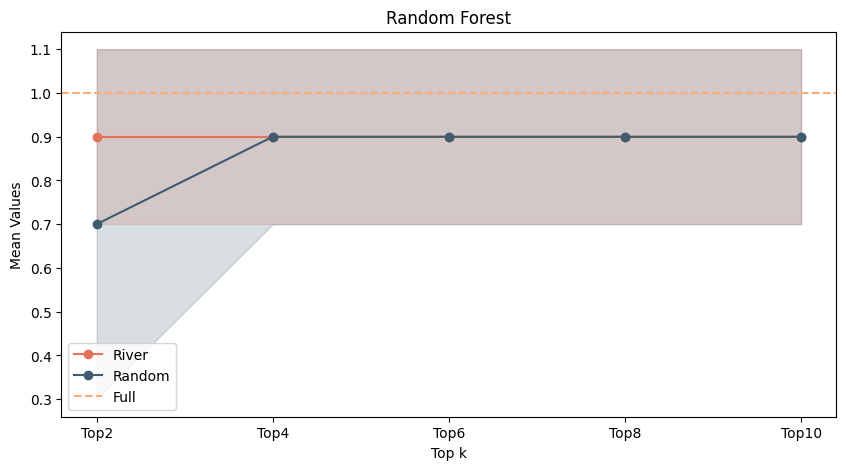

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


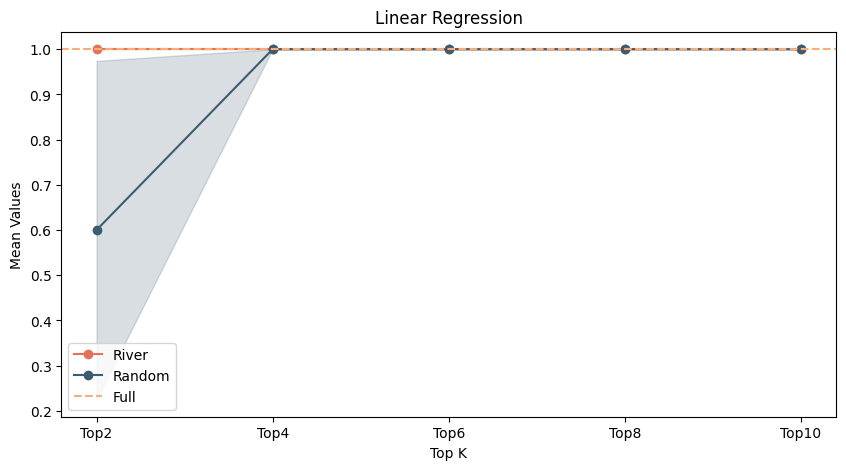

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
methods = ['Top2', 'Top4', 'Top6', 'Top8', 'Top10']
group1_means = np.array(means_1[:5])
group2_means = np.array(means_c_1[:5])
group1_stds = np.array(std_1[:5])
group2_stds = np.array(std_c_1[:5])



plt.figure(figsize=(10, 5))
plt.plot(methods, group1_means, '-o', label='River', color='#E47159')  # Plot for Group 1
plt.fill_between(methods, group1_means - group1_stds, group1_means + group1_stds, color='#E47159', alpha=0.2)
plt.plot(methods, group2_means, '-o', label='Random', color='#3D5C6F')   # Plot for Group 2
plt.fill_between(methods, group2_means - group2_stds, group2_means + group2_stds, color='#3D5C6F', alpha=0.2)
plt.axhline(y=means_3[-1], color='#F9AE78', linestyle='--', label='Full')
plt.xlabel('Top k')
plt.ylabel('Mean Values')
plt.title('Support Vector Machine')
plt.legend()  # Adds a legend to differentiate between the two groups
plt.show()


import matplotlib.pyplot as plt
import numpy as np


group1_means = np.array(means_2[:5])
group2_means = np.array(means_c_2[:5])
group1_stds = np.array(std_2[:5])
group2_stds = np.array(std_c_2[:5])

# Creating line chart for two groups
plt.figure(figsize=(10, 5))
plt.plot(methods, group1_means, '-o', label='River', color='#E47159')  # Plot for Group 1
plt.fill_between(methods, group1_means - group1_stds, group1_means + group1_stds, color='#E47159', alpha=0.2)
plt.plot(methods, group2_means, '-o', label='Random', color='#3D5C6F')   # Plot for Group 2
plt.fill_between(methods, group2_means - group2_stds, group2_means + group2_stds, color='#3D5C6F', alpha=0.2)
plt.axhline(y=means_3[-1], color='#F9AE78', linestyle='--', label='Full')
plt.xlabel('Top k')
plt.ylabel('Mean Values')
plt.title('Random Forest')
plt.legend()  # Adds a legend to differentiate between the two groups
plt.show()


import matplotlib.pyplot as plt
import numpy as np


group1_means = np.array(means_3[:5])
group2_means = np.array(means_c_3[:5])
group1_stds = np.array(std_3[:5])
group2_stds = np.array(std_c_3[:5])



plt.figure(figsize=(10, 5))
plt.plot(methods, group1_means, '-o', label='River', color='#E47159')  # Plot for Group 1
plt.fill_between(methods, group1_means - group1_stds, group1_means + group1_stds, color='#E47159', alpha=0.2)
plt.plot(methods, group2_means, '-o', label='Random', color='#3D5C6F')   # Plot for Group 2
plt.fill_between(methods, group2_means - group2_stds, group2_means + group2_stds, color='#3D5C6F', alpha=0.2)
plt.axhline(y=means_3[-1], color='#F9AE78', linestyle='--', label='Full')
plt.xlabel('Top K')
plt.ylabel('Mean Values')
plt.title('Linear Regression')
plt.legend()  # Adds a legend to differentiate between the two groups
plt.show()



/tmp/ipykernel_252884/2676978491.py:14: ImplicitModificationWarning: Setting element `.obsm['ig']` of view, initializing view as actual.
  adata_t.obsm['ig'] = scores_ig
/data/civy/miniconda3/lib/python3.10/site-packages/scanpy-1.9.3-py3.10.egg/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


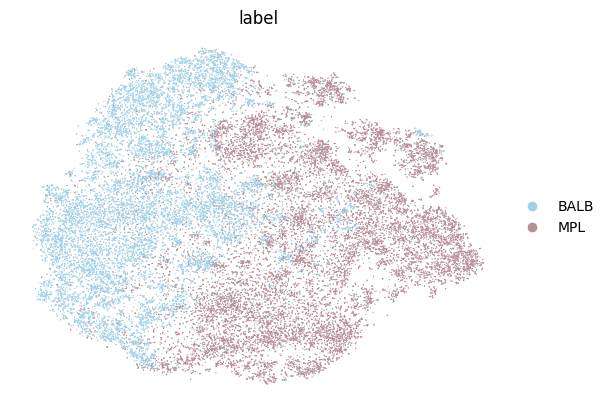

/data/civy/miniconda3/lib/python3.10/site-packages/scanpy-1.9.3-py3.10.egg/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


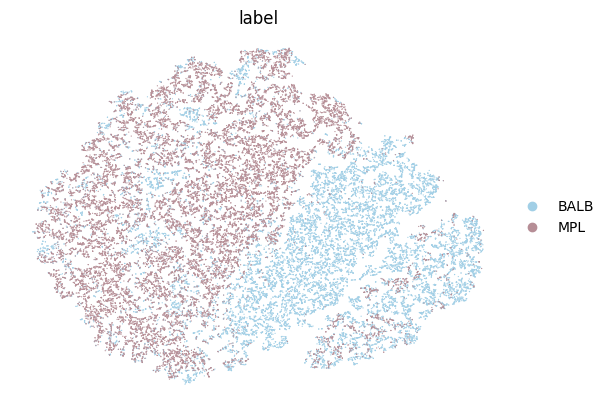

/data/civy/miniconda3/lib/python3.10/site-packages/scanpy-1.9.3-py3.10.egg/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


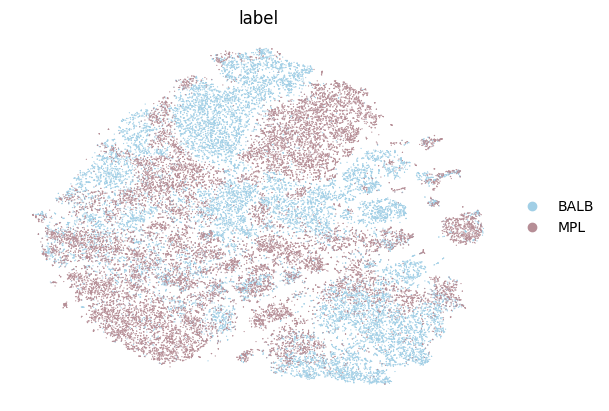

/data/civy/miniconda3/lib/python3.10/site-packages/scanpy-1.9.3-py3.10.egg/scanpy/tools/_tsne.py:155: ImplicitModificationWarning: Setting element `.obsm['X_tsne']` of view, initializing view as actual.
  adata.obsm['X_tsne'] = X_tsne  # annotate samples with tSNE coordinates
/data/civy/miniconda3/lib/python3.10/site-packages/scanpy-1.9.3-py3.10.egg/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


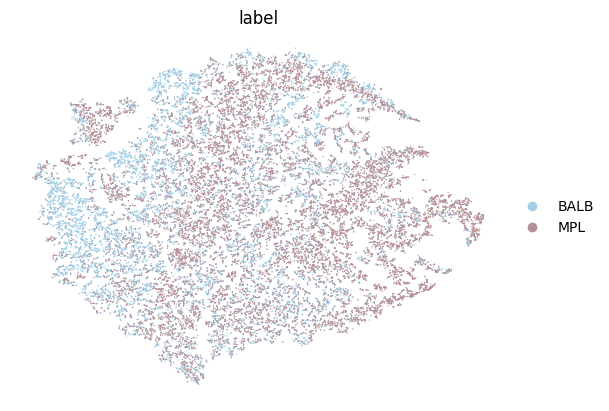

In [39]:
import anndata as ad

final_ranks = np.load('final_rank_lupus.npy', allow_pickle=True)

scores_ig = np.load('ig_lupus.npy')
scores_dl = np.load('dl_lupus.npy')
scores_sl = np.load('sl_lupus.npy')

our_genes = final_ranks[:5]


adata_t = ad.concat(adata_list, label='slice_id')[:, our_genes]

adata_t.obsm['ig'] = scores_ig


sc.tl.tsne(adata_t, use_rep='ig')
ax = sc.pl.tsne(adata_t, color='label', show=False, palette=['#a1cfe6', '#b68e96'])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()


sc.tl.tsne(adata_t)
ax = sc.pl.tsne(adata_t, color='label', show=False, palette=['#a1cfe6', '#b68e96'])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()


adata_all =  ad.concat(adata_list, label='slice_id')
sc.tl.tsne(adata_all)
ax = sc.pl.tsne(adata_all, color='label', show=False, palette=['#a1cfe6', '#b68e96'])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()


our_genes = final_ranks[-5:]
adata_t = ad.concat(adata_list, label='slice_id')[:, our_genes]
sc.tl.tsne(adata_t)
ax = sc.pl.tsne(adata_t, color='label', show=False, palette=['#a1cfe6', '#b68e96'])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()
